# CNN Visualization

## Team 🧑‍🔬🧑‍🔬🧑‍🔬🧑‍🔬

- Trevor Dohm
- Reece Iriye
- Leland Winston
- Kassi Bertrand

# Could be the beginning of Question 1? 

In [1]:
import os
import sys
import torch
import numpy as np
import torch.nn as nn
import PIL
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models import vgg16, VGG16_Weights
from torchsummary import summary

# NOTE: TorchVision offers pre-trained weights for every provided architecture, using the PyTorch torch.hub. 
# Instancing a pre-trained model will download its weights to a cache directory. 
# This directory can be set using the TORCH_HOME environment variable
os.environ['TORCH_HOME'] = './TORCH_HOME'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

`VGG-16` has 13 convolutional layers and 3 fully connected layers. Feeding an arbitrary image of size $(3 \times 256 \times 256)$ and we get the following summary alongside the output shapes and corresponding paramater count:

In [2]:
# VGG-16 using pretrained weights
vgg = vgg16(weights=VGG16_Weights.DEFAULT).to(device)

# Freeze VGG
vgg.eval()

summary(vgg, (3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

Here is also the classic Pytorch Summary as it contains more information about the dimensions of the filters:

In [3]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Question 2



Our team was interested in the multi-channel filter in `Conv 3-3`, the 7th convolution layer counting from the left.

![VGG-16 Archicture diagram](imgs/img-0.png)

`Conv 3-3` corresponds to `Conv2d-15`, the 15th layer in our architecture summary:

```txt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
           Conv2d-15          [-1, 256, 64, 64]         590,080
================================================================
```

Assuming the batch size being $1$, this layer accepts an input with shape: $(1 \times 256 \times 64 \times 64)$, convolves it with *256 filters*, and produces another tensor of shape $(1 \times 256 \times 64 \times 64)$. Let's start start look at the activations of this layer, when an image passes through it.

### Exploring Activation Patterns in a Specific Convolutional Layer.

Let's display the activations (i.e. the 256 filters) of this `Conv2d-15` when we feed in the following image in the network:

![Test Input image](imagenet-samples/test.JPEG)

To make our life easy, the team used the following snippet to captures the activations in `vgg.features` as an input image travels throughout those layers.

In [4]:
activations_store = {}

def hook_fn(layer_index):
    def hook(module, input, output):
        activations_store[layer_index] = output.detach()
    return hook

# Register hooks for all layers in vgg.features
for layer_index, layer in enumerate(vgg.features):
    layer.register_forward_hook(hook_fn(layer_index))

In [5]:
import torchvision.transforms as transforms
from PIL import Image

# Define the transformation for the input image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),  # Crop the center of the image to make it square (256x256)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = Image.open('imagenet-samples/test.JPEG')

# Preprocess the image
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension
input_batch = input_batch.to(device)

# Perform inference
with torch.no_grad():
    output = vgg(input_batch) # (1, 1000)

# Get the index corresponding to the maximum score
_, predicted_idx = torch.max(output, 1)

print("Index of the prediction:", predicted_idx.item())

Index of the prediction: 998


`VGG-16` predicted that the test image belongs to the $998^{th}$ class. Which is correct! Index `998` corresponds to the class: `ear, spike, capitulum`.

Now that we know the model made the correct prediction, let's print out the activations of convolutional layer: `Conv2d-15` just to see what they picked on. Those activations are stored in the `activations` dictionary we created earlier.

In [6]:
activations_store[14].shape

torch.Size([1, 256, 64, 64])

The team wrote the following helper to make displaying the activations of convolutional layers in the network easier

In [7]:
def display_activations(activations: torch.Tensor):
    """
    Display activations in a grid using matplotlib.
    
    Args:
    - activations: Activations tensor of shape [1, channels, height, width]
    """
    # Get the dimensions
    batch_size, num_channels, height, width = activations.shape
    
    # Calculate the number of rows and columns for the grid
    num_rows = int(np.ceil(np.sqrt(num_channels)))
    num_cols = int(np.ceil(num_channels / num_rows))
    
    # Create a figure and axis objects
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 40))
    
    # Iterate over each channel and display it in the corresponding subplot
    for i in range(num_rows):
        for j in range(num_cols):
            # Calculate the channel index
            channel_idx = i * num_cols + j
            
            # Check if channel index is within the range of available channels
            if channel_idx < num_channels:
                # Get the activation for the current channel
                activation = activations[0, channel_idx]
                
                # Display the activation
                axes[i, j].imshow(activation, cmap='hot', interpolation='nearest')  # Using 'hot' colormap
                axes[i, j].axis('off')
            else:
                # If there are less channels than subplots, remove the empty subplot
                fig.delaxes(axes[i, j])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

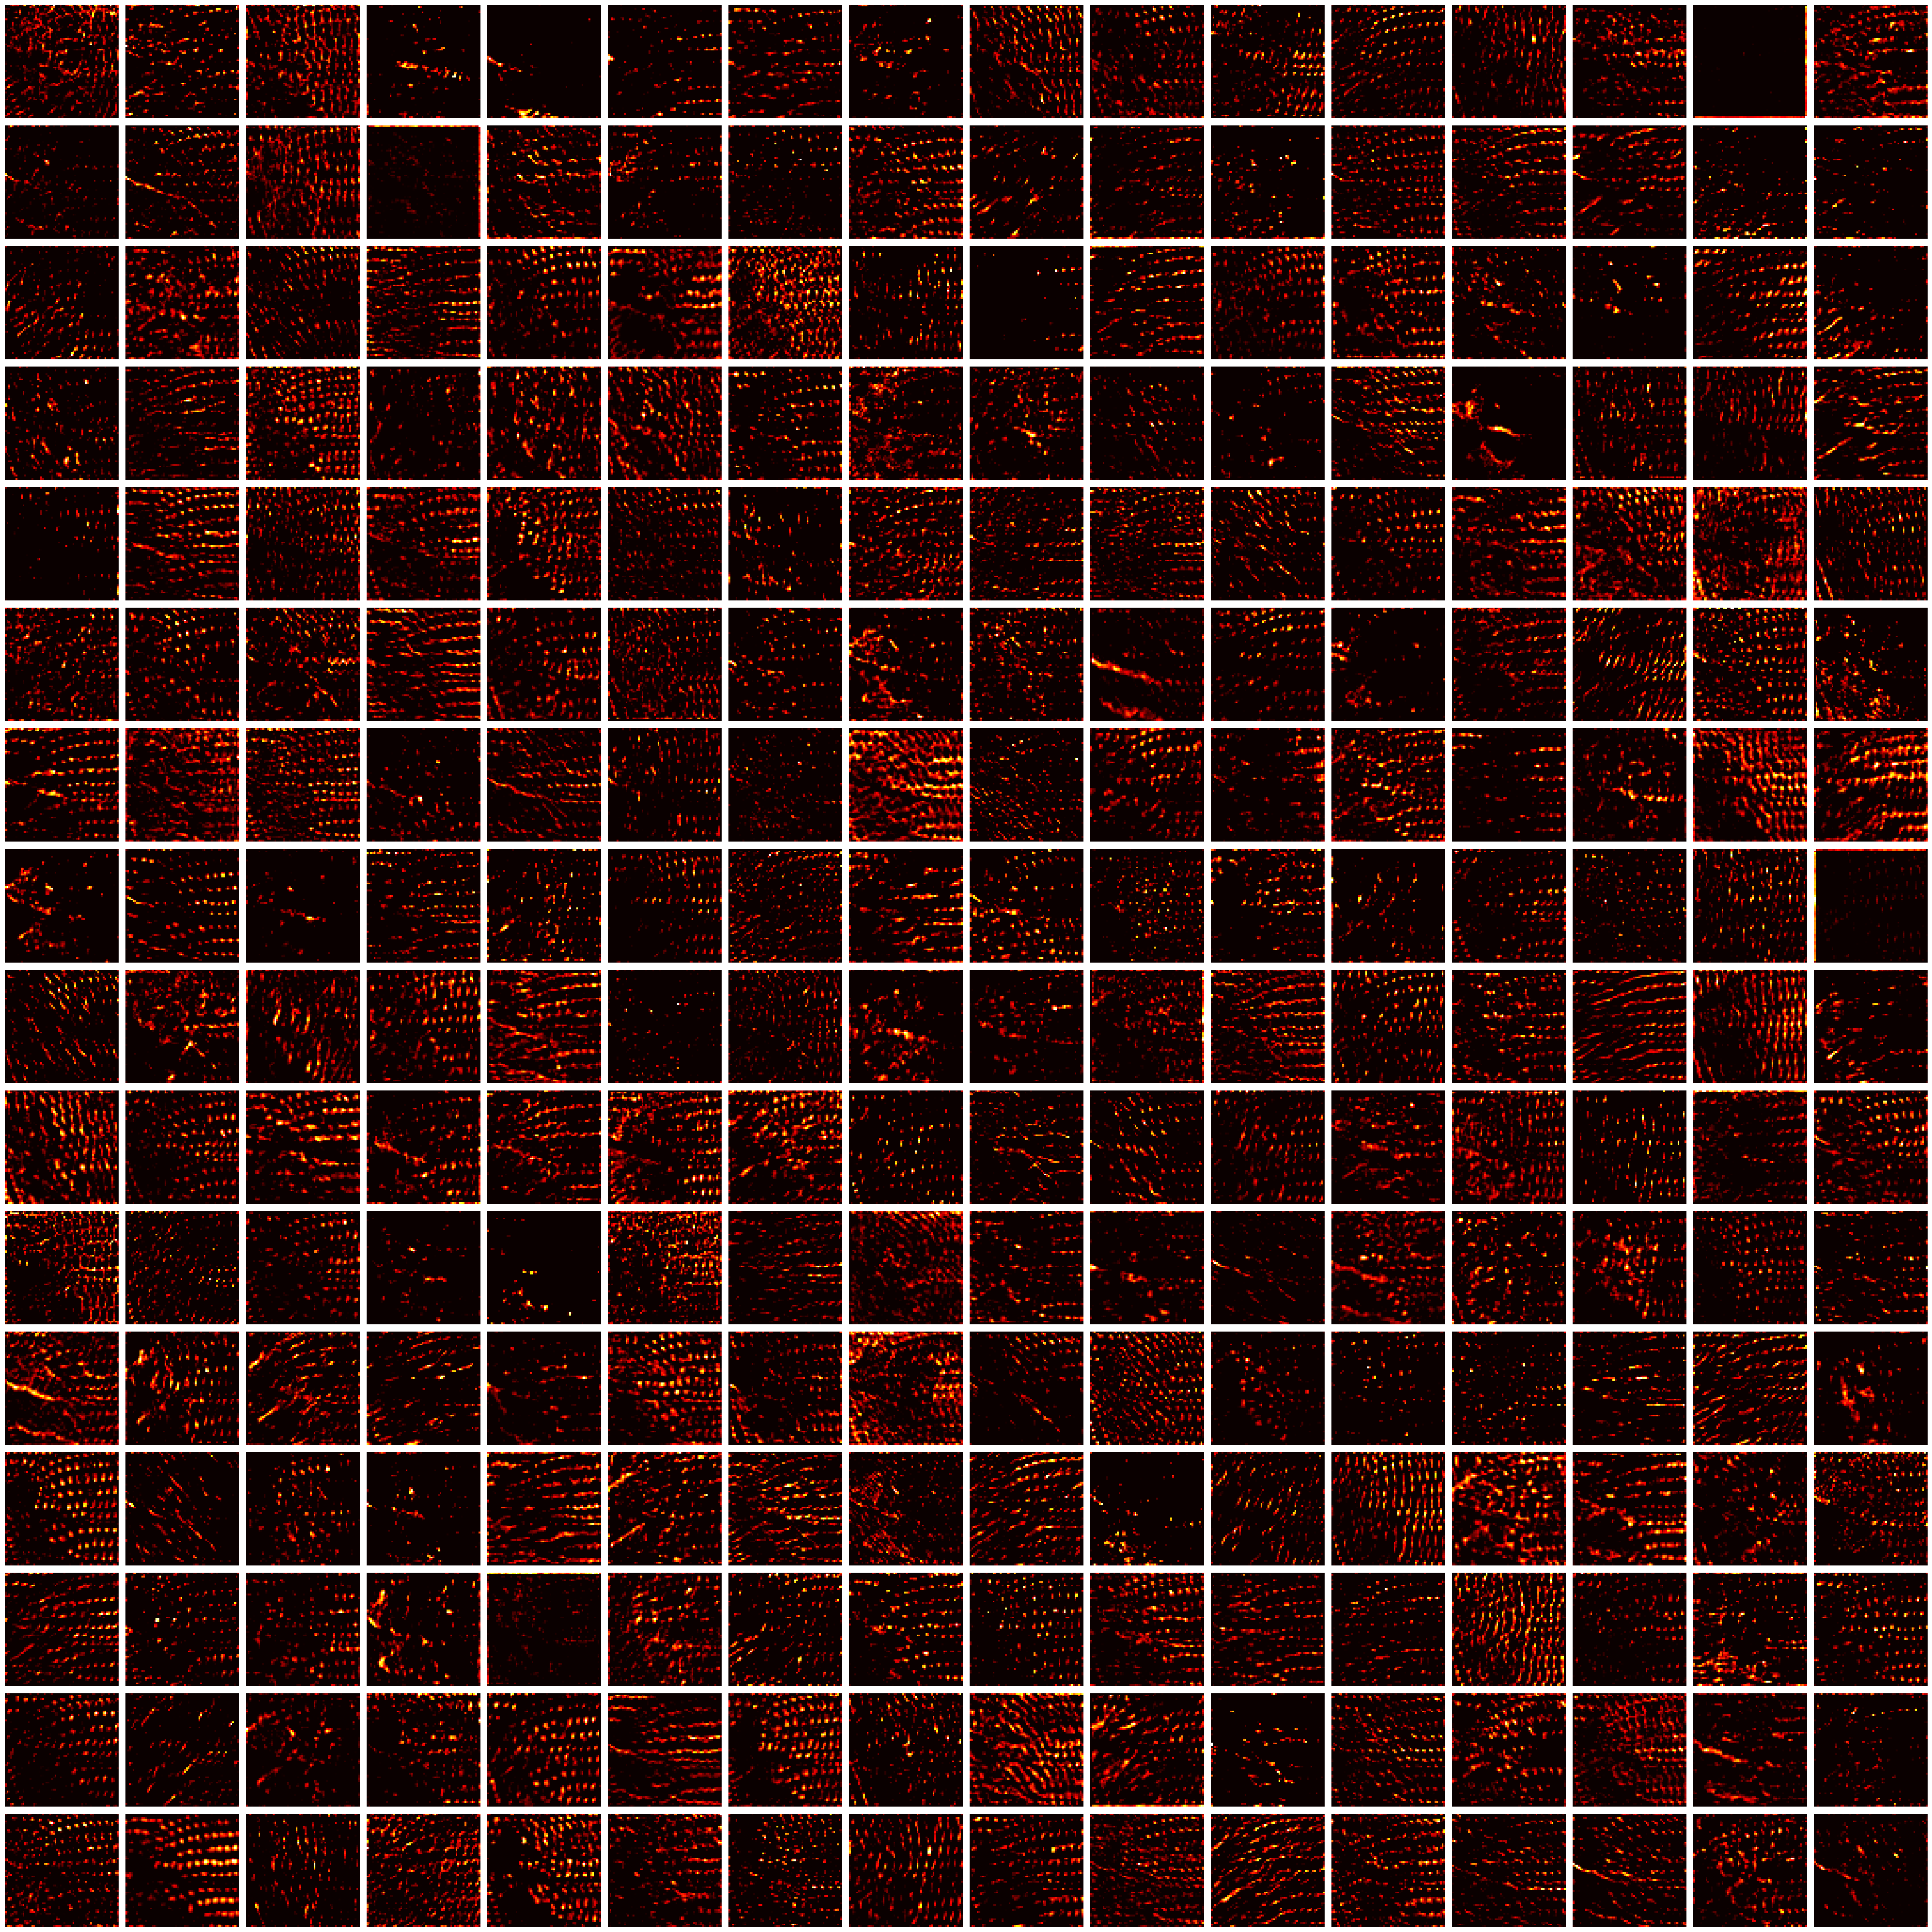

In [8]:
# Display the activations of the 15th layer in the network
display_activations(activations_store[14].cpu())

It looks like the `Conv2d-15` picks up on the yellow grains for the most part, at least judging by the heatmap above.

### Using gradient techniques, find an input image that maximally excites the chosen filter.

To find an input image that maximally excites a given channel in a mutli-channel filter, the team used the following function.

In [9]:
def find_max_excitation_image(target_conv_layer: int, filter_index, optimization_steps: int = 100, show_loss=True):

    # Define a random input image or initialize with random noise
    input_image = torch.randn(1, 3, 256, 256, requires_grad=True, device=device)  # Random noise image

    # Define the optimizer # NOTE: The list of paramaters to optimize is specified. 
    # Only the input image will get updated.
    optimizer = torch.optim.Adam([input_image], lr=0.01)

    # Optimization loop
    for step in range(optimization_steps):
        # Forward pass. NOTE: This line selects the layers from the beginning of the VGG network (vgg.features) 
        # up to the layer specified by target_conv_layer, then feedforward "input_image". 
        output = vgg.features[: target_conv_layer](input_image)

        # Get the activations of the chosen filter
        activations = output[:, filter_index] # (64, 64)
        
        # By negating the mean activation, My goal was to turn the problem into 
        # an optimization task where the objective is to minimize 
        # the negative of the mean activation. In other words, 
        # to maximize the mean activation
        loss = -torch.mean(activations)
        
        # Zero gradients, perform a backward pass, and update the input image
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print progress
        if show_loss:
            if (step+1) % 10 == 0:
                print(f'Step [{step+1}/{optimization_steps}], Loss: {loss.item()}')

    return input_image

With the previously defined `find_max_excitation_image`, let's find the image that maximally excites the 3rd filter in the chosen multi-channel filter.

In [10]:
target_conv_layer = 14 # "Conv2d-15" layer. The 15th layer in the network
filter_index = 2 # The 3rd filter in the "Conv2d-15"

optimized_image = find_max_excitation_image(target_conv_layer, filter_index, 200, show_loss=True)

Step [10/200], Loss: -14.956369400024414
Step [20/200], Loss: -23.495750427246094
Step [30/200], Loss: -30.838184356689453
Step [40/200], Loss: -37.43147277832031
Step [50/200], Loss: -43.517051696777344
Step [60/200], Loss: -49.19957733154297
Step [70/200], Loss: -54.58610534667969
Step [80/200], Loss: -59.756038665771484
Step [90/200], Loss: -64.77316284179688
Step [100/200], Loss: -69.6671142578125
Step [110/200], Loss: -74.46946716308594
Step [120/200], Loss: -79.2140884399414
Step [130/200], Loss: -83.91893005371094
Step [140/200], Loss: -88.59139251708984
Step [150/200], Loss: -93.25225830078125
Step [160/200], Loss: -97.90973663330078
Step [170/200], Loss: -102.56924438476562
Step [180/200], Loss: -107.23629760742188
Step [190/200], Loss: -111.90804290771484
Step [200/200], Loss: -116.59904479980469


Let's save the image in the `imgs` folder, then display it.

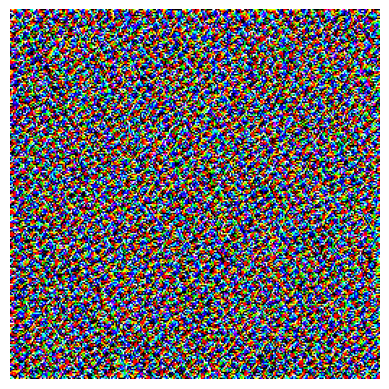

In [11]:
# Convert the optimized image tensor to a numpy array, then make sure px values are within [0, 1]
optimized_image = optimized_image.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
optimized_image = np.clip(optimized_image, 0, 1)

# Convert numpy array to PIL image, then save it
optimized_image_pil = Image.fromarray((optimized_image * 255).astype(np.uint8))
optimized_image_pil.save("imgs/optimized_image.png")

plt.imshow(optimized_image)
plt.axis('off')
plt.show()

### Send images of varying class (i.e., from ImageNet) through the network and track which classes of images most excite your chosen filter. 

> **(NOTE to the TEAM)**: If my SSH in vscode was not broken. We could (using Superpod) feed **all** the images of Imagenet one at a time, and record "how excited" our filter becomes, we could then use this information to produce a plot and see which class of all the 1000 our filter responds the most to, that you'd be sick 💉😈, i think. I think we should seriously consider it, because it'd make our hypothesis straightforward, and make it easy to give the reason behind our hypothesis.

In the meantime, i set aside just a few images (see `imagenet-samples` folder) to feed the network, and compute the average activation value in the 3rd channel of the multi channel filter in layer `Conv2d-15`. let's write a little helper for that.


In [12]:

def average_activation(image_path: str, target_conv_layer: int, filter_index):
    """
    Calculate the average activation of a specific filter in a convolutional layer's multi-channel filter 
    of a pre-trained VGG network for a given input image.

    Args:
        image_path (str): The file path to the input image.
        target_conv_layer (int): Index of the target convolutional layer in the network.
        filter_index (int): Index of the filter within the target convolutional layer.

    Returns:
        float: The average activation value of the specified filter for the given image.

    Note:
        This function assumes that 'vgg' and 'activations_store' are globally defined.
        'vgg' refers to the pre-trained VGG network model.
        'activations_store' should be a dictionary containing activations of 'vgg.features'.

    Example:
        >>> avg_activation = average_activation('image.jpg', 2, 10)
    """

    # Define the transformation for the input image
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),  # Crop the center of the image to make it square (256x256)
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path)

    # Preprocess the image
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension
    input_batch = input_batch.to(device)

    # Perform inference
    with torch.no_grad():
        output = vgg(input_batch) # (1, 1000)

    # Grab the activations of the channel we are interested in
    multi_channel_filter_activations = activations_store[target_conv_layer]
    filter_activations = multi_channel_filter_activations[:, filter_index]

    # Compute the average value.
    return filter_activations.cpu().mean().item()


In [13]:
avg_activation_995 = average_activation('imagenet-samples/n13044778_1584.JPEG', 14, 2)
avg_activation_996 = average_activation('imagenet-samples/n13052670_927.JPEG', 14, 2)
avg_activation_997 = average_activation('imagenet-samples/n13054560_3313.JPEG', 14, 2)
avg_activation_998 = average_activation('imagenet-samples/n13133613_47898.JPEG', 14, 2)
avg_activation_999 = average_activation('imagenet-samples/n15075141_1746.JPEG', 14, 2)

print(avg_activation_995)
print(avg_activation_996)
print(avg_activation_997)
print(avg_activation_998)
print(avg_activation_999)

1.573606252670288
0.5731528997421265
0.935560405254364
1.2559322118759155
0.960648775100708


Remember earlier we used gradient ascent ascent to find the the image that maximally excite the third filter too, let's see:


In [14]:
average_activation('imgs/optimized_image.png', 14, 2)

2.3967597484588623

It looks like the optimized image excites the third filter in `Conv2d-15` the most.